# Tutorial on implementing boundary conditions in an A grid

In [another notebook](https://ndViewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_stuck_particles.ipynb), we have shown how particles may end up getting stuck on land, especially in A gridded velocity fields. Here we show how you can work around this problem and how large the change in trajectory is.

Common solutions are:
1. [Delete the particles](#1.-Particle-deletion)
2. [Displace the particles when they are within a certain distance of the coast.](#2.-Displacement)
3. [Reduce the landward component of the particle velocity](#3.-Onshore-velocity-reduction)

In all of these solutions, kernels are used to modify the trajectories near the coast. The kernels all consist of two parts:
1. Flag particles whose trajectory should be modified
2. Modify the trajectory accordingly

This notebook is mainly focused on the second part, comparing the different modifications to the trajectory. The first part is also very relevant however and further discussion on this is enouraged. Some options shown here are:
1. Flag particles within a specific distance to the shore
2. Flag particles in any gridcell that has a shore edge

As argued in the [previous notebook](https://ndViewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/documentation_stuck_particles.ipynb), it is of great importance to show the grid discretization accurately to understand the motion of particles near the boundary. The velocity fields can best be depicted using points or arrows that define the velocity at a single position. Four of these nodes then form gridcells that can be shown using tiles, for example with `matplotlib.pyplot.pcolormesh`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from netCDF4 import Dataset
import xarray as xr
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, Variable, Field,GeographicPolar,Geographic
from datetime import timedelta as delta
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy
from scipy import interpolate
import cmocean

INFO: Compiled ParcelsRandom ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\libparcels_random_ffc37f1d-6f27-4d10-8ff4-9abbce80f3e0.so


## 1. Particle deletion
The simplest way to avoid trajectories that interact with the coastline is to remove them entirely. To do this, all `Particle` objects have a delete function that can be invoked in a kernel using `particle.delete()`

## 2. Displacement
A simple concept to avoid particles moving onto shore is displacing them towards the ocean as they get close to shore. This is done in [Kaandorp et al. 2020](https://pubs.acs.org/doi/10.1021/acs.est.0c01984) and [Delandmeter and Sebille 2018](https://gmd.copernicus.org/articles/12/3571/2019/) for example. To do so, a particle must be 'aware' of where the shore is and displaced accordingly. In Parcels, we can do this by adding a 'displacement' `Field` to the `Fieldset`, which contains vectors pointing away from shore. 
#### Import a velocity field - the A gridded SMOC product

In [2]:
file_path = "SMOC_20190704_R20190705.nc"
model = xr.open_dataset(file_path)

In [3]:
# --------- Define meshgrid coordinates to plot velocity field with matplotlib pcolormesh ---------
latmin = 1595
latmax = 1612
lonmin = 2235
lonmax = 2260

# Velocity nodes
lon_vals, lat_vals = np.meshgrid(model['longitude'], model['latitude'])
lons_plot = lon_vals[latmin:latmax,lonmin:lonmax]
lats_plot = lat_vals[latmin:latmax,lonmin:lonmax]

dlon = 1/12 #np.mean(np.diff(model['longitude']))
dlat = 1/12 #np.mean(np.diff(model['latitude']))

# Centers of the gridcells formed by 4 nodes = velocity nodes + 0.5 dx
x = model['longitude'][:-1]+np.diff(model['longitude'])/2
y = model['latitude'][:-1]+np.diff(model['latitude'])/2
lon_centers, lat_centers = np.meshgrid(x, y)

color_land = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(128)

####  Make a landmask where `land = 1` and `ocean = 0`.

In [4]:
def make_landmask(fielddata):
    """Returns landmask where land = 1 and ocean = 0
    fielddata is a netcdf file.
    """
    datafile = Dataset(fielddata)

    landmask = datafile.variables['uo'][0, 0]
    landmask = np.ma.masked_invalid(landmask)
    landmask = landmask.mask.astype('int')

    return landmask

In [5]:
landmask = make_landmask(file_path)

In [6]:
# Interpolate the landmask to the cell centers - only cells with 4 neighbouring land points will be land
fl = interpolate.interp2d(model['longitude'],model['latitude'],landmask)

l_corners = fl(lon_centers[0,:],lat_centers[:,0])  

lmask = np.ma.masked_values(l_corners,1) # land when interpolated value == 1

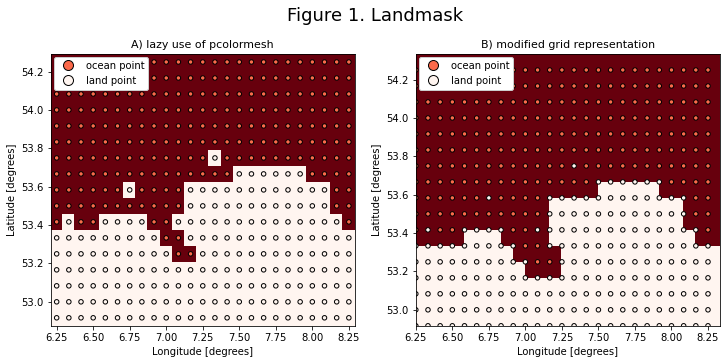

In [7]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Figure 1. Landmask', fontsize=18, y=1.01)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_title('A) lazy use of pcolormesh', fontsize=11)
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

land0 = ax0.pcolormesh(lons_plot, lats_plot, landmask[latmin:latmax,lonmin:lonmax],cmap='Reds_r', shading='auto')
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05,edgecolors='k')

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax0.legend(custom_lines, ['ocean point', 'land point'], bbox_to_anchor=(.01,.93), loc='center left', borderaxespad=0.,framealpha=1)

ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title('B) modified grid representation', fontsize=11)
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')

land1 = ax1.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax1.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05,edgecolors='k')

ax1.legend(custom_lines, ['ocean point', 'land point'], bbox_to_anchor=(.01,.93), loc='center left', borderaxespad=0.,framealpha=1)

Figure 1 shows why it is important to be precise when visualizing the model land and ocean. Parcels trajectories should not cross the land boundary between two land nodes as seen in 1B.

#### Detect the coast

By computing 

$$\partial_{xx} \text{landmask} + \partial_{yy} \text{landmask}$$

and filtering the positve and negative values we can detect the edges, in this case the coast (ocean nodes next to land) and the shore (land nodes next to the ocean).

In [8]:
def get_coastal_nodes(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes directly
    next to land. Computes the Laplacian of landmask.

    - landmask: the land mask dUilt using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    coastal = np.ma.masked_array(landmask, mask_lap > 0)
    coastal = coastal.mask.astype('int')

    return coastal

def get_shore_nodes(landmask):
    """Function that detects the shore nodes, i.e. the land nodes directly
    next to the ocean. Computes the Laplacian of landmask.

    - landmask: the land mask dUilt using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the shore nodes, the shore nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    shore = np.ma.masked_array(landmask, mask_lap < 0)
    shore = shore.mask.astype('int')

    return shore

In [9]:
coastal = get_coastal_nodes(landmask)
shore = get_shore_nodes(landmask)

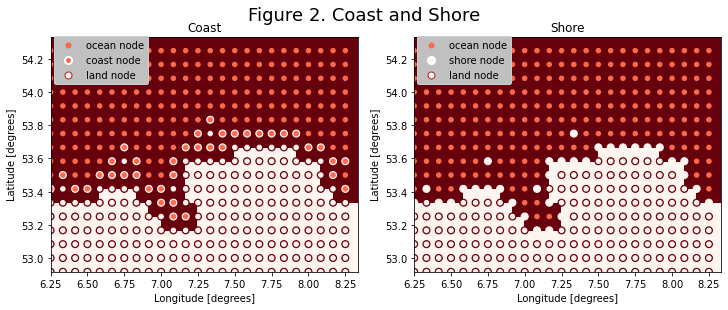

In [10]:
fig = plt.figure(figsize=(10,4), constrained_layout=True)
fig.suptitle('Figure 2. Coast and Shore', fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)


ax0 = fig.add_subplot(gs[0, 0])
land0 = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
coa = ax0.scatter(lons_plot,lats_plot, c=coastal[latmin:latmax,lonmin:lonmax], cmap='Reds_r', s=50)
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05)

ax0.set_title('Coast')
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=5, lw=0),
                Line2D([0], [0], c = color_ocean, marker='o', markersize=7, markeredgecolor='w', markeredgewidth=2, lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=7, markeredgecolor='firebrick', lw=0)]
ax0.legend(custom_lines, ['ocean node', 'coast node', 'land node'], bbox_to_anchor=(.01,.9), loc='center left', borderaxespad=0.,framealpha=1, facecolor='silver')


ax1 = fig.add_subplot(gs[0, 1])
land1 = ax1.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
sho = ax1.scatter(lons_plot,lats_plot, c=shore[latmin:latmax,lonmin:lonmax], cmap='Reds_r', s=50)
ax1.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=20,cmap='Reds_r',vmin=-0.05,vmax=0.05)

ax1.set_title('Shore')
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=5, lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=7, markeredgecolor='w', markeredgewidth=2, lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=7, markeredgecolor='firebrick', lw=0)]
ax1.legend(custom_lines, ['ocean node', 'shore node', 'land node'], bbox_to_anchor=(.01,.9), loc='center left', borderaxespad=0.,framealpha=1, facecolor='silver')

#### Assigning coastal velocities

For the displacement kernel we define a velocity field that pushes the particles back to the ocean. This velocity has to be a vector normal to the shore. For this we can take the simple derivative of `landmask` and project the result to the `shore` array, this will capture the orientation of the velocity vectors. then to make this vectors unitary, we can normalize by it's magnitude.

In [11]:
def create_displacement_field(landmask, double_cell=False):
    """Function that creates a displacement field 1 m/s away from the shore.

    - landmask: the land mask dUilt using `make_landmask`.
    - double_cell: Boolean for determining if you want a double cell.
      Default set to False.

    Output: two 2D arrays, one for each camponent of the velocity.
    """
    shore = get_shore_nodes(landmask)
    coastal = get_coastal_nodes(landmask)
    Ly = np.roll(landmask, -1, axis=0) - np.roll(landmask, 1, axis=0)
    Lx = np.roll(landmask, -1, axis=1) - np.roll(landmask, 1, axis=1)
    
    if double_cell:
        v_x = -Lx*(coastal+shore) 
        v_y = -Ly*(coastal+shore)
    else:
        v_x = -Lx*(shore)
        v_y = -Ly*(shore)

    magnitude = np.sqrt(v_y**2 + v_x**2)
    # the coastal nodes between land create a problem. Magnitude there is zero
    # I force it to be 1 to avoid problems when normalizing.
    ny, nx = np.where(magnitude == 0)
    magnitude[ny, nx] = 1

    v_x = v_x/magnitude
    v_y = v_y/magnitude

    return v_x, v_y

In [12]:
# v_x, v_y = create_displacement_field(landmask)
# np.save('coastal_u.npy', v_x)
# np.save('coastal_v.npy', v_y)
v_x = np.load('coastal_u.npy',allow_pickle=True)
v_y = np.load('coastal_v.npy',allow_pickle=True)

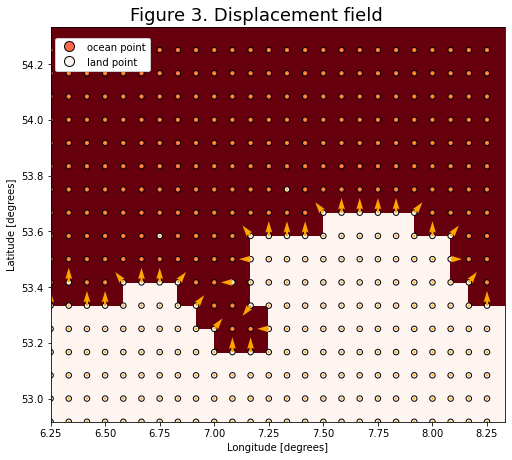

In [13]:
fig = plt.figure(figsize=(7,6), constrained_layout=True)
fig.suptitle('Figure 3. Displacement field', fontsize=18, y=1.04)
gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
land = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=30,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
quiv = ax0.quiver(lons_plot,lats_plot,v_x[latmin:latmax,lonmin:lonmax],v_y[latmin:latmax,lonmin:lonmax],color='orange',angles='xy', scale_units='xy', scale=19, width=0.005)

ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax0.legend(custom_lines, ['ocean point', 'land point'], bbox_to_anchor=(.01,.93), loc='center left', borderaxespad=0.,framealpha=1)

#### Calculate the distance to the shore
In this tutorial, we will displace particles that are within some distance to the shore. For this we need to compute that distance for the entire field and let our particles sample this field. This gives a crude estimate of the distance.

In [14]:
def distance_to_shore(landmask, dx=1):
    """Function that computes the distance to the shore. It is based in the
    the `get_coastal_nodes` algorithm.

    - landmask: the land mask dUilt using `make_landmask` function.
    - dx: the grid cell dimesion. This is a crude approximation of the real
    distance (be careful).

    Output: 2D array containing the distances from shore.
    """
    ci = get_coastal_nodes(landmask)
    landmask_i = landmask + ci
    dist = ci
    i = 0

    while i < dist.max():
        ci = get_coastal_nodes(landmask_i)
        landmask_i += ci
        dist += ci*(i+2)
        i += 1
        
    return dist*dx

In [15]:
# d_2_s = distance_to_shore(landmask)
# np.save('distance_2_shore.npy', d_2_s)
d_2_s = np.load('distance_2_shore.npy')

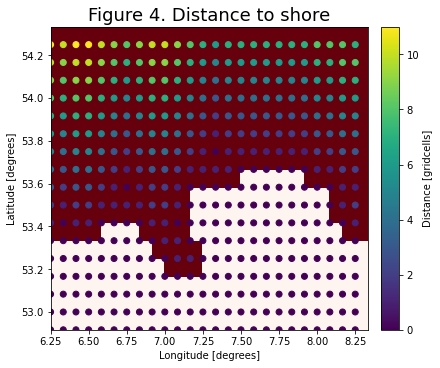

In [16]:
fig = plt.figure(figsize=(6,5), constrained_layout=True)

ax0 = fig.add_subplot()
ax0.set_title('Figure 4. Distance to shore', fontsize=18)
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')

land = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
d2s = ax0.scatter(lons_plot,lats_plot, c=d_2_s[latmin:latmax,lonmin:lonmax])

plt.colorbar(d2s,ax=ax0, label='Distance [gridcells]')

#### Simulation
Now let us test the displacement of the particles as they approach the shore.

In [17]:
SMOCfile = 'SMOC_201907*.nc'
filenames = {'U': SMOCfile,
             'V': SMOCfile}

variables = {'U': 'uo',
             'V': 'vo'}

dimensions = {'U': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
              'V': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

In [18]:
u_displacement = v_x #np.load('coastal_u.npy')
v_displacement = v_y #np.load('coastal_v.npy')
fieldset.add_field(Field('dispU', data=u_displacement,
                         lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                         mesh='spherical'))
fieldset.add_field(Field('dispV', data=v_displacement,
                         lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                         mesh='spherical'))
fieldset.dispU.units = GeographicPolar()
fieldset.dispV.units = Geographic()

In [19]:
fieldset.add_field(Field('landmask', landmask,
                         lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                         mesh='spherical'))
fieldset.add_field(Field('distance2shore', d_2_s,
                         lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                         mesh='spherical'))

In [20]:
class LandParticle(JITParticle):
    on_land = Variable('on_land')
    dU = Variable('dU')
    dV = Variable('dV')
    d2s = Variable('d2s', initial=1e3)
    
def Sample_land(particle, fieldset, time):
    particle.on_land = fieldset.landmask[time, particle.depth, particle.lat, particle.lon]
    particle.d2s = fieldset.distance2shore[time, particle.depth,
                               particle.lat, particle.lon]
    if  particle.d2s < 0.5:
        dispUab = fieldset.dispU[time, particle.depth, particle.lat,
                               particle.lon]
        dispVab = fieldset.dispV[time, particle.depth, particle.lat,
                               particle.lon]
        particle.dU = dispUab
        particle.dV = dispVab
    else:
        particle.dU = 0.
        particle.dV = 0.
    
def AntiBeachNudging(particle, fieldset, time):
    """
    The nudging current is 1 m s^-1, which ought to be sufficient to overpower
    any coastal current (I hope) and push our particle back out to sea so as to
    not get stuck
    update 11/03/2020: Following tests and discussions with Cleo, the nudging
    current will now kick in starting at 500m from the coast, since otherwise
    the particles tended to get stuck if we used the velocity treshhold.
    """
    
    if  particle.d2s < 0.5:
        particle.lon += particle.dU*particle.dt
        particle.lat += particle.dV*particle.dt

In [21]:
npart = 3  # number of particles to be released
lon = np.linspace(7, 7.2, npart, dtype=np.float32)
lat = np.linspace(53.45, 53.6, npart, dtype=np.float32)
lons, lats = np.meshgrid(lon,lat)
time = np.zeros(lons.size)

pset = ParticleSet(fieldset=fieldset, pclass=LandParticle, lon=lons, lat=lats, time=time)

kernels = pset.Kernel(AntiBeachNudging)+pset.Kernel(AdvectionRK4)+pset.Kernel(Sample_land)

output_file = pset.ParticleFile(name="SMOC-disp.nc", outputdt=delta(hours=1))

pset.execute(kernels, runtime=delta(hours=119), dt=delta(minutes=1),
             output_file=output_file)
output_file.close()

INFO: Compiled ArrayLandParticleAntiBeachNudgingAdvectionRK4Sample_land ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\lib3a13e2604d095cd2b6ebeb8cfd267fc1_0.dll
INFO: Temporary output files are stored in out-WCOXYELP.
INFO: You can use "parcels_convert_npydir_to_netcdf out-WCOXYELP" to convert these to a NetCDF file during the run.
100% (428400.0 of 428400.0) |############| Elapsed Time: 0:02:52 Time:  0:02:52


#### Output
To see the effect of the displacement, the particle trajectory output can be compared to the simulation without the displacement kernel.

In [22]:
ds_SMOC = xr.open_dataset('SMOC.nc')
ds_SMOC_disp = xr.open_dataset('SMOC-disp.nc')

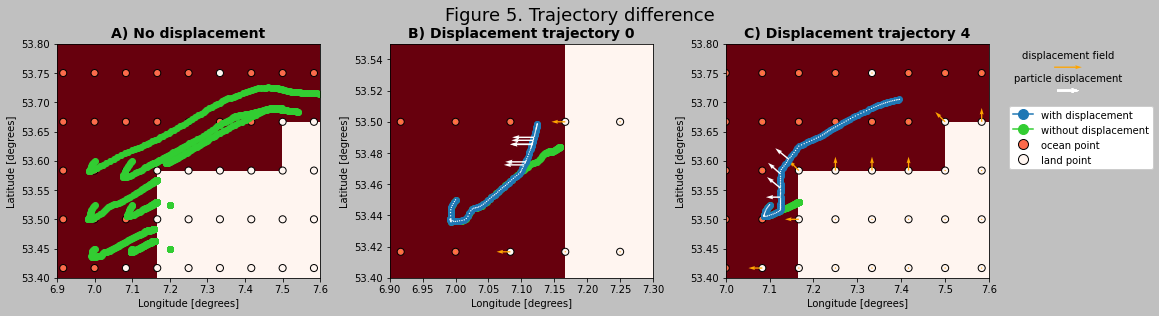

In [23]:
fig = plt.figure(figsize=(16,4), facecolor='silver', constrained_layout=True)
fig.suptitle('Figure 5. Trajectory difference', fontsize=18, y=1.06)
gs = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=[1,1,1,0.3], figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')
ax0.set_title('A) No displacement', fontsize=14, fontweight = 'bold')
ax0.set_xlim(6.9, 7.6)
ax0.set_ylim(53.4, 53.8)

land = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=50,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
ax0.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,linewidth=3, zorder=1)
ax0.scatter(ds_SMOC['lon'], ds_SMOC['lat'], color='limegreen', zorder=2)

n_p0 = 0
ax1 = fig.add_subplot(gs[0, 1])
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('B) Displacement trajectory '+str(n_p0), fontsize=14, fontweight = 'bold')
ax1.set_xlim(6.9, 7.3)
ax1.set_ylim(53.4, 53.55)

land = ax1.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax1.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=50,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
quiv = ax1.quiver(lons_plot,lats_plot,v_x[latmin:latmax,lonmin:lonmax],v_y[latmin:latmax,lonmin:lonmax],color='orange', scale=19, width=0.005)
ax1.plot(ds_SMOC_disp['lon'][n_p0].T, ds_SMOC_disp['lat'][n_p0].T,linewidth=3, zorder=1)
ax1.scatter(ds_SMOC['lon'][n_p0], ds_SMOC['lat'][n_p0], color='limegreen', zorder=2)
ax1.scatter(ds_SMOC_disp['lon'][n_p0], ds_SMOC_disp['lat'][n_p0], cmap='viridis_r', zorder=2)
ax1.quiver(ds_SMOC_disp['lon'][n_p0], ds_SMOC_disp['lat'][n_p0],ds_SMOC_disp['dU'][n_p0], ds_SMOC_disp['dV'][n_p0], color='w',angles='xy', scale_units='xy', scale=2e-4, zorder=3)

n_p1 = 4
ax2 = fig.add_subplot(gs[0, 2])
ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('C) Displacement trajectory '+str(n_p1), fontsize=14, fontweight = 'bold')
ax2.set_xlim(7., 7.6)
ax2.set_ylim(53.4, 53.8)

land = ax2.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax2.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=50,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
q1 = ax2.quiver(lons_plot,lats_plot,v_x[latmin:latmax,lonmin:lonmax],v_y[latmin:latmax,lonmin:lonmax],color='orange', scale=19, width=0.005)
ax2.plot(ds_SMOC_disp['lon'][n_p1].T, ds_SMOC_disp['lat'][n_p1].T,linewidth=3, zorder=1)
ax2.scatter(ds_SMOC['lon'][n_p1], ds_SMOC['lat'][n_p1], color='limegreen', zorder=2)
ax2.scatter(ds_SMOC_disp['lon'][n_p1], ds_SMOC_disp['lat'][n_p1], cmap='viridis_r', zorder=2)
q2 = ax2.quiver(ds_SMOC_disp['lon'][n_p1], ds_SMOC_disp['lat'][n_p1],ds_SMOC_disp['dU'][n_p1], ds_SMOC_disp['dV'][n_p1], color='w',angles='xy', scale_units='xy', scale=2e-4, zorder=3)


ax3 = fig.add_subplot(gs[0, 3])
ax3.axis('off')
custom_lines = [Line2D([0], [0], c = 'tab:blue', marker='o', markersize=10),
                Line2D([0], [0], c = 'limegreen', marker='o', markersize=10),
                Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax3.legend(custom_lines, ['with displacement', 'without displacement', 'ocean point', 'land point'], bbox_to_anchor=(0.,0.6), loc='center left', borderaxespad=0.,framealpha=1)

ax2.quiverkey(q1, 1.3, 0.9, 2, 'displacement field', coordinates='axes')
ax2.quiverkey(q2, 1.3, 0.8, 1e-5, 'particle displacement', coordinates='axes')
plt.show()

#### Conclusion
Figure 5 shows how particles are prevented from approaching the coast in a 5 day simulation. Note that to show each computation, the integration timestep is equal to the output timestep: 1 hour. This is relatively large, and causes the displacement to be on the order of 4 km and be relatively infrequent.

In [24]:
d2s_cmap = copy(plt.get_cmap('cmo.deep_r'))
d2s_cmap.set_over('gold')

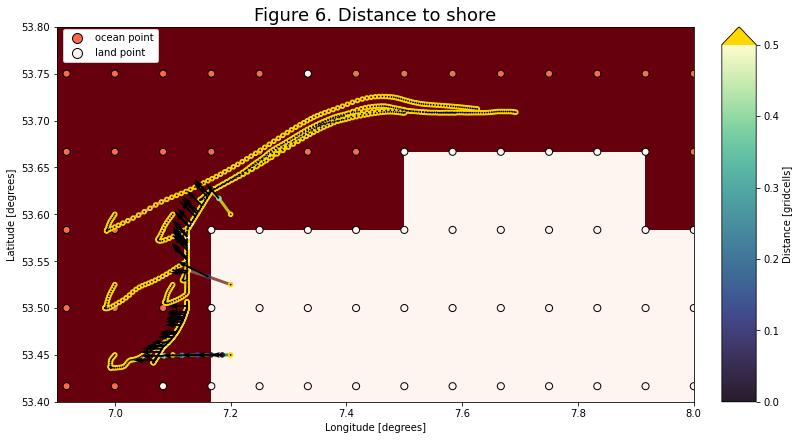

In [25]:
fig = plt.figure(figsize=(11,6), constrained_layout=True)

ax0 = fig.add_subplot()
ax0.set_title('Figure 6. Distance to shore', fontsize=18)
land = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=50,cmap='Reds_r', edgecolor='k',vmin=-0.05,vmax=0.05)
ax0.plot(ds_SMOC_disp['lon'].T, ds_SMOC_disp['lat'].T,linewidth=3, zorder=1)
d2s = ax0.scatter(ds_SMOC_disp['lon'], ds_SMOC_disp['lat'], c=ds_SMOC_disp['d2s'],cmap=d2s_cmap, s=20,vmax=0.5, zorder=2)
q2 = ax0.quiver(ds_SMOC_disp['lon'], ds_SMOC_disp['lat'],ds_SMOC_disp['dU'], ds_SMOC_disp['dV'], color='k',angles='xy', scale_units='xy', scale=2.3e-4, width=0.003, zorder=3)

ax0.set_xlim(6.9, 8)
ax0.set_ylim(53.4, 53.8)
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')
plt.colorbar(d2s,ax=ax0, label='Distance [gridcells]',extend='max')

color_land = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(128)

custom_lines = [Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax0.legend(custom_lines, ['ocean point', 'land point'], bbox_to_anchor=(.01,.95), loc='center left', borderaxespad=0.,framealpha=1)


## 3. Onshore velocity reduction
The reason trajectories do not neatly follow the coast in A grid velocity fields is that the lack of staggering causes both velocity components to go to zero in the same way towards the cell edge. Another solution is to reduce the cross-shore component of velocity by a factor that depends on the position within the cell. To do this, the direction to shore is mapped and the velocity in the advection kernel is modified according to this direction and the relative position in the cell.

In [26]:
def get_boundary_direction(landmask):
    """Function that detects the boundaries for a gridcell [i,j] defined by the nodes [i,j], [i+1,j], [i+1,j+1] and [i,j+1]
    When i and j increase with longitude and latitude, this defines the gridcell [i,j] with node [i,j] in the southwest corner.
    Directions are mapped according to figure 7.
    """
    bound_dir = np.logical_and(landmask, np.roll(landmask, -1, axis=1)).astype(int)
    bound_dir += 2*np.logical_and(np.roll(landmask, -1, axis=0), np.roll(landmask, (-1,-1), axis=(0,1))).astype(int)
    bound_dir += 4*np.logical_and(landmask, np.roll(landmask, -1, axis=0)).astype(int)
    bound_dir += 8*np.logical_and(np.roll(landmask, -1, axis=1), np.roll(landmask, (-1,-1), axis=(0,1))).astype(int)
    bound_dir = bound_dir[:-1,:-1]
    
    return bound_dir

In [27]:
bound_dir = get_boundary_direction(landmask)

In [28]:
dir_cmap = copy(plt.get_cmap('jet',14))
dir_cmap.set_under([0,0,0,0])
dir_cmap.set_over([0,0,0,0])

Text(0.5, 1.0, 'Binary values for boundary directions')

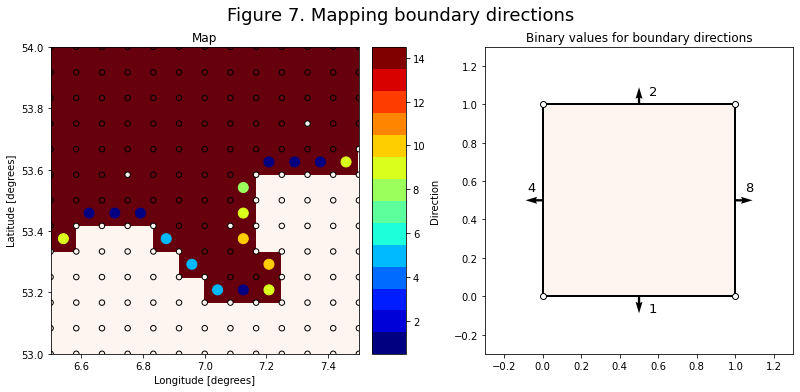

In [29]:
fig = plt.figure(figsize=(11,5), constrained_layout=True)
fig.suptitle('Figure 7. Mapping boundary directions', fontsize=18, y=1.06)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])

land1 = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')

lm = ax0.scatter(lons_plot, lats_plot,c=landmask[latmin:latmax,lonmin:lonmax],s=30,cmap='Reds_r', vmax=0.5,edgecolor='k')
bd = ax0.scatter(lon_centers[latmin:latmax,lonmin:lonmax], lat_centers[latmin:latmax,lonmin:lonmax],c=bound_dir[latmin:latmax,lonmin:lonmax],s=100,cmap=dir_cmap, vmin=0.5,vmax=14.5)

ax0.set_title('Map')

plt.colorbar(bd, label = 'Direction')
ax0.set_xlim(6.5,7.5)
ax0.set_ylim(53,54)
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')


ax1 = fig.add_subplot(gs[0, 1])

ax1.pcolormesh(np.array([[0,0],[1,1]]),np.array([[0,1],[0,1]]),np.array([[1]]), cmap='Reds',edgecolor='k')
ax1.scatter(np.array([[0,0],[1,1]]),np.array([[0,1],[0,1]]), c='w', edgecolor='k')
ax1.quiver(np.array([0,0.5,1,0.5]),np.array([0.5,0,0.5,1]),np.array([-1,0,1,0]),np.array([0,-1,0,1]))
ax1.text(-0.08,0.55,'4',fontsize=13)
ax1.text(0.55,-0.08,'1',fontsize=13)
ax1.text(1.05,0.55,'8',fontsize=13)
ax1.text(0.55,1.05,'2',fontsize=13)
ax1.set_xlim(-0.3,1.3)
ax1.set_ylim(-0.3,1.3)
ax1.set_title('Binary values for boundary directions')

#### Modify velocities
There are different ways to modify the velocity as to prevent particles from reaching the land. In the first kernel the cross-shore velocity goes to zero parabolically. In the second kernel, the cross-shore velocity is reduced linearly.

In [30]:
def AdvectionRK4_2D_ParabolicBoundary(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration.

    Adapted from Parcels code, this Kernel interpolates the velocities differently close to solid objects.

    Needs to be used in combination with the BoundaryParticle class to access boundary directions in particle.boundary

    Only works on regular grids where the location within a grid cell can be found with the coordinate origin (x0, y0) and dx and dy"""

    (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    lon1 = particle.lon + u1 * .5 * particle.dt
    lat1 = particle.lat + v1 * .5 * particle.dt
    (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1]
    lon2 = particle.lon + u2 * .5 * particle.dt
    lat2 = particle.lat + v2 * .5 * particle.dt
    (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2]
    lon3 = particle.lon + u3 * particle.dt
    lat3 = particle.lat + v3 * particle.dt
    (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3]

    # Determine final velocities to be checked against the directions of the boundaries
    u_final = (u1 + 2 * u2 + 2 * u3 + u4) / 6.
    v_final = (v1 + 2 * v2 + 2 * v3 + v4) / 6.

    B_binary = particle.boundary # do not change particle.boundary in this kernel
    n_boundary = 0               # counter to keep track of the amount of boundarys

    f_u = 1
    lon_cell = (particle.lon - fieldset.x0 + 0.5 * fieldset.dx) / fieldset.dx
    xsi = lon_cell - math.floor(lon_cell)
    f_v = 1
    lat_cell = (particle.lat - fieldset.y0 + 0.5 * fieldset.dy) / fieldset.dy
    eta = lat_cell - math.floor(lat_cell)

    if B_binary >= 8:  # boundary right
        B_binary += -8
        if xsi > 0.5:
            f_u = 4 * math.pow(1 - xsi, 2)  # no cross-boundary movement
            f_v = 2 - 2 * xsi
            n_boundary += 1
    if B_binary >= 4:  # boundary left
        B_binary += -4
        if xsi < 0.5 and n_boundary == 0:
            f_u = 4 * math.pow(xsi, 2)
            f_v = 2 * xsi
            n_boundary += 1
    if B_binary >= 2:  # boundary below
        B_binary += -2
        if eta > 0.5 and n_boundary == 0:
            f_u = 2 - 2 * eta
            f_v = 4 * math.pow(1 - eta, 2)
            n_boundary += 1
        elif eta > 0.5 and particle.boundary > 8:
            if xsi - eta < 0:
                f_u = 2 - 2 * eta
                f_v = 4 * math.pow(1 - eta, 2)
                n_boundary += 1
            elif xsi - eta > 0:
                f_u = 4 * math.pow(1 - xsi, 2)
                f_v = 2 - 2 * xsi
                n_boundary += 1
        elif eta > 0.5 and particle.boundary > 4:
            if xsi + eta > 1:
                f_u = 2 - 2 * eta
                f_v = 4 * math.pow(1 - eta, 2)
                n_boundary += 1
            elif xsi + eta < 1:
                f_u = 4 * math.pow(xsi, 2)
                f_v = 2 * xsi
                n_boundary += 1
    if B_binary == 1:  # boundary above
        if eta < 0.5 and n_boundary == 0:
            f_u = 2 * eta
            f_v = 4 * math.pow(eta, 2)
            n_boundary += 1
        elif eta < 0.5 and particle.boundary > 8:
            if xsi + eta > 1:
                f_u = 4 * math.pow(1 - xsi, 2)
                f_v = 2 - 2 * xsi
                n_boundary += 1
            elif xsi + eta < 1:
                f_u = 2 * eta
                f_v = 4 * math.pow(eta, 2)
                n_boundary += 1
        elif eta < 0.5 and particle.boundary > 4:
            if xsi - eta < 0:
                f_u = 4 * math.pow(xsi, 2)
                f_v = 2 * xsi
                n_boundary += 1
            elif xsi - eta > 0:
                f_u = 2 * eta
                f_v = 4 * math.pow(eta, 2)
                n_boundary += 1


    particle.lon += f_u * u_final * particle.dt
    particle.lat += f_v * v_final * particle.dt
    particle.xsi = xsi
    particle.eta = eta
    particle.f_u = f_u
    particle.f_v = f_v

In [31]:
def AdvectionRK4_2D_PartialSlip_center_Boundary(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration.

    Adapted from Parcels code, this Kernel interpolates the velocities differently close to solid objects.

    Needs to be used in combination with the BoundaryParticle class to access boundary directions in particle.boundary

    Only works on regular grids where the location within a grid cell can be found with the coordinate origin (x0, y0) and dx and dy"""

    (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    lon1 = particle.lon + u1 * .5 * particle.dt
    lat1 = particle.lat + v1 * .5 * particle.dt
    (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1]
    lon2 = particle.lon + u2 * .5 * particle.dt
    lat2 = particle.lat + v2 * .5 * particle.dt
    (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2]
    lon3 = particle.lon + u3 * particle.dt
    lat3 = particle.lat + v3 * particle.dt
    (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3]

    # Determine final velocities to be checked against the directions of the boundaries
    u_final = (u1 + 2 * u2 + 2 * u3 + u4) / 6.
    v_final = (v1 + 2 * v2 + 2 * v3 + v4) / 6.

    B_binary = particle.boundary # do not change particle.boundary in this kernel
    n_boundary = 0               # counter to keep track of the amount of boundarys

    f_u = 1
    lon_cell = (particle.lon - fieldset.x0 + 0.5 * fieldset.dx) / fieldset.dx
    xsi = lon_cell - math.floor(lon_cell)
    f_v = 1
    lat_cell = (particle.lat - fieldset.y0 + 0.5 * fieldset.dy) / fieldset.dy
    eta = lat_cell - math.floor(lat_cell)

    if B_binary >= 8:  # boundary right
        B_binary += -8
        if xsi > 0.5:
            f_u = 1 - xsi  # no cross-boundary movement
            f_v = 1
            n_boundary += 1
    if B_binary >= 4:  # boundary left
        B_binary += -4
        if xsi < 0.5:
            f_u = xsi
            f_v = 1
            n_boundary += 1
    if B_binary >= 2:  # boundary below
        B_binary += -2
        if eta > 0.5 and n_boundary == 0:
            f_u = 1
            f_v = 1 - eta
            n_boundary += 1
        elif eta > 0.5 and particle.boundary > 8:
            if xsi - eta < 0:
                f_u = 1
                f_v = 1 - eta
                n_boundary += 1
            elif xsi - eta > 0:
                f_u = 1 - xsi
                f_v = 1
                n_boundary += 1
        elif eta > 0.5 and particle.boundary > 4:
            if xsi + eta > 1:
                f_u = 1
                f_v = 1 - eta
                n_boundary += 1
            elif xsi + eta < 1:
                f_u = xsi
                f_v = 1
                n_boundary += 1
    if B_binary == 1:  # boundary above
        if eta < 0.5 and n_boundary == 0:
            f_u = 1
            f_v = eta
            n_boundary += 1
        elif eta < 0.5 and particle.boundary > 8:
            if xsi + eta > 1:
                f_u = 1 - xsi
                f_v = 1
                n_boundary += 1
            elif xsi + eta < 1:
                f_u = 1
                f_v = eta
                n_boundary += 1
        elif eta < 0.5 and particle.boundary > 4:
            if xsi - eta < 0:
                f_u = xsi
                f_v = 1
                n_boundary += 1
            elif xsi - eta > 0:
                f_u = 1
                f_v = eta
                n_boundary += 1


    particle.lon += f_u * u_final * particle.dt
    particle.lat += f_v * v_final * particle.dt
    particle.xsi = xsi
    particle.eta = eta
    particle.f_u = f_u
    particle.f_v = f_v

Note that the relative position within a cell, defined by the coordinates xsi and eta, is calculated from a reference point (x0,y0) and dx and dy. This means that it only works in a regular grid. To use parcels more advanced methods, [this method](https://github.com/OceanParcels/parcels/blob/documentation_getting_unstuck/parcels/application_kernels/advection.py#L127) can be used in SciPy.

In [32]:
class BoundaryParticle(JITParticle):  # Define a new particle class that is aware of the solid-fluid boundaries
    boundary = Variable('boundary', dtype=np.float32, initial=0.)
    xsi = Variable('xsi')
    eta = Variable('eta')
    f_u = Variable('f_u')
    f_v = Variable('f_v')

In [33]:
def Samples(particle, fieldset, time):  # Custom function that samples d2c, closestobject and border at particle location
    particle.boundary = fieldset.boundary[time, particle.depth, particle.lat, particle.lon]

In [34]:
SMOCfile = 'SMOC_201907*.nc'
filenames = {'U': SMOCfile,
             'V': SMOCfile}

variables = {'U': 'uo',
             'V': 'vo'}

dimensions = {'U': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
              'V': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

boundary_field = Field('boundary', bound_dir, lon=lon_centers, lat=lat_centers)

fieldset.add_field(boundary_field)
fieldset.boundary.interp_method = 'nearest'

# Set boundary grid
fieldset.add_constant('x0', model['longitude'][lonmin])
fieldset.add_constant('y0', model['latitude'][latmin])
fieldset.add_constant('dx', model['longitude'][lonmin+1]-model['longitude'][lonmin])
fieldset.add_constant('dy', model['latitude'][latmin+1]-model['latitude'][latmin])

npart = 3  # number of particles to be released
lon = np.linspace(7, 7.2, npart, dtype=np.float32)
lat = np.linspace(53.45, 53.6, npart, dtype=np.float32)
lons, lats = np.meshgrid(lon,lat)
time = np.zeros(lons.size)

pset = ParticleSet(fieldset=fieldset, pclass=BoundaryParticle, lon=lons, lat=lats, time=time)

kernels = pset.Kernel(AdvectionRK4_2D_ParabolicBoundary) + pset.Kernel(Samples)

output_file = pset.ParticleFile(name="SMOC_parab.nc", outputdt=delta(hours=1))

pset.execute(kernels, runtime=delta(hours=119), dt=delta(hours=1),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

INFO: Compiled ArrayBoundaryParticleAdvectionRK4_2D_ParabolicBoundarySamples ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\lib1e5c3916966b9b8f0bdded6a7d70c024_0.dll
INFO: Temporary output files are stored in out-DKSRONKL.
INFO: You can use "parcels_convert_npydir_to_netcdf out-DKSRONKL" to convert these to a NetCDF file during the run.
100% (428400.0 of 428400.0) |############| Elapsed Time: 0:02:58 Time:  0:02:58


In [35]:
ds_SMOC_parab = xr.open_dataset('SMOC_parab.nc')
ds_SMOC_part = xr.open_dataset('SMOC_partialslip.nc')
ds_SMOC_disp_dt = xr.open_dataset('SMOC-disp-dt.nc')

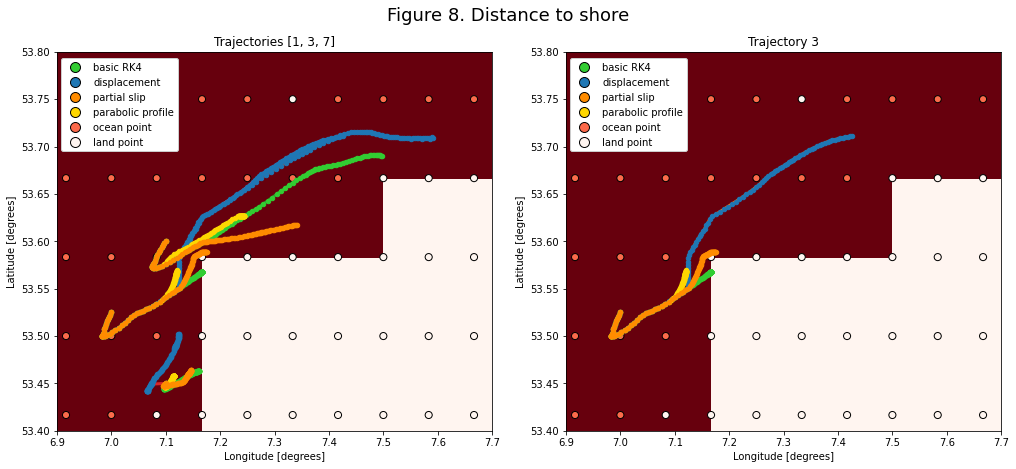

In [36]:
fig = plt.figure(figsize=(14,6), constrained_layout=True)
fig.suptitle('Figure 8. Distance to shore', fontsize=18, y=1.06)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

n_p1=[1,3,7]

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_title('Trajectories '+str(n_p1))
land = ax0.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax0.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=50,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')
# q1 = ax0.quiver(lons_plot,lats_plot,v_x[latmin:latmax,lonmin:lonmax],v_y[latmin:latmax,lonmin:lonmax],color='orange', scale=19, width=0.005)

ax0.plot(ds_SMOC['lon'][n_p1].T, ds_SMOC['lat'][n_p1].T,linewidth=3, zorder=1)
ax0.scatter(ds_SMOC['lon'][n_p1], ds_SMOC['lat'][n_p1], s=20, color='limegreen', zorder=2)

ax0.plot(ds_SMOC_disp_dt['lon'][n_p1].T, ds_SMOC_disp_dt['lat'][n_p1].T,linewidth=3, zorder=1)
ax0.scatter(ds_SMOC_disp_dt['lon'][n_p1], ds_SMOC_disp_dt['lat'][n_p1], s=20,  color='tab:blue', zorder=2)

ax0.plot(ds_SMOC_parab['lon'][n_p1].T, ds_SMOC_parab['lat'][n_p1].T,linewidth=3, zorder=1)
ax0.scatter(ds_SMOC_parab['lon'][n_p1], ds_SMOC_parab['lat'][n_p1], s=20, color='gold', zorder=2)

ax0.plot(ds_SMOC_part['lon'][n_p1].T, ds_SMOC_part['lat'][n_p1].T,linewidth=3, zorder=1)
ax0.scatter(ds_SMOC_part['lon'][n_p1], ds_SMOC_part['lat'][n_p1], s=20, color='darkorange', zorder=2)

ax0.set_xlim(6.9, 7.7)
ax0.set_ylim(53.4, 53.8)
ax0.set_ylabel('Latitude [degrees]')
ax0.set_xlabel('Longitude [degrees]')


n_p2=3

ax1 = fig.add_subplot(gs[0, 1])
ax1.set_title('Trajectory '+str(n_p2))
land = ax1.pcolormesh(lon_vals[latmin:latmax+1,lonmin:lonmax+1], lat_vals[latmin:latmax+1,lonmin:lonmax+1], lmask.mask[latmin:latmax,lonmin:lonmax],cmap='Reds_r')
ax1.scatter(lons_plot, lats_plot, c=landmask[latmin:latmax,lonmin:lonmax],s=50,cmap='Reds_r',vmin=-0.05,vmax=0.05, edgecolors='k')

ax1.plot(ds_SMOC['lon'][n_p2].T, ds_SMOC['lat'][n_p2].T,linewidth=3, zorder=1)
ax1.scatter(ds_SMOC['lon'][n_p2], ds_SMOC['lat'][n_p2], s=20, color='limegreen', zorder=2)

ax1.plot(ds_SMOC_disp_dt['lon'][n_p2].T, ds_SMOC_disp_dt['lat'][n_p2].T,linewidth=3, zorder=1)
ax1.scatter(ds_SMOC_disp_dt['lon'][n_p2], ds_SMOC_disp_dt['lat'][n_p2], s=20,  color='tab:blue', zorder=2)

ax1.plot(ds_SMOC_parab['lon'][n_p2].T, ds_SMOC_parab['lat'][n_p2].T,linewidth=3, zorder=1)
ax1.scatter(ds_SMOC_parab['lon'][n_p2], ds_SMOC_parab['lat'][n_p2], s=20, color='gold', zorder=2)

ax1.plot(ds_SMOC_part['lon'][n_p2].T, ds_SMOC_part['lat'][n_p2].T,linewidth=3, zorder=1)
ax1.scatter(ds_SMOC_part['lon'][n_p2], ds_SMOC_part['lat'][n_p2], s=20, color='darkorange', zorder=2)

ax1.set_xlim(6.9, 7.7)
ax1.set_ylim(53.4, 53.8)
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')


color_land = copy(plt.get_cmap('Reds'))(0)
color_ocean = copy(plt.get_cmap('Reds'))(128)

custom_lines = [Line2D([0], [0], c = 'limegreen', marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = 'tab:blue', marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = 'darkorange', marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = 'gold', marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_ocean, marker='o', markersize=10, markeredgecolor='k', lw=0),
                Line2D([0], [0], c = color_land, marker='o', markersize=10, markeredgecolor='k', lw=0)]
ax0.legend(custom_lines, ['basic RK4','displacement','partial slip', 'parabolic profile','ocean point', 'land point'], bbox_to_anchor=(.01,.86), loc='center left', borderaxespad=0.,framealpha=1)
ax1.legend(custom_lines, ['basic RK4','displacement','partial slip', 'parabolic profile','ocean point', 'land point'], bbox_to_anchor=(.01,.86), loc='center left', borderaxespad=0.,framealpha=1)
